# Analysis of the Phase function calculated by Vadim 22th April

In [2]:
from __future__ import division
%matplotlib inline
import pickle
import datetime
from dateutil import parser
import itertools
import math
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8.0, 8.0)
import numpy as np
import os
import pandas as pd
from scipy.integrate import quadrature, romberg, quad, fixed_quad
from scipy.interpolate import interp1d
from scipy.special import legendre
from tqdm import tqdm_notebook

from IPython.display import Image
from IPython.core.display import HTML 

## Load the Phase Function

Vadim calculated the phase function for the different measurements during the flight. I arbitrarily take measurement number 300.

In [53]:
TIME_INDEX = 300
GREEN_CH_INDEX = 1

In [23]:
with open("/VISL2_net/amitibo/exports/MieCalculationDataForPython2_22_04_2017.pkl", "rb") as f:
    data = pickle.load(f)

In [24]:
data.keys()

[u'TimeLable',
 u'AngleLabel',
 u'Used_wavelengths',
 u'Used_refractive_index',
 u'scatt_cross_sect',
 u'date',
 u'Phase_Total']

In [47]:
WAVELENGTH = int(data[u'Used_wavelengths'][GREEN_CH_INDEX] * 1000)

In [55]:
ssa = data[u'scatt_cross_sect'][TIME_INDEX][GREEN_CH_INDEX]

In [33]:
pf = data[u'Phase_Total'][TIME_INDEX, :, GREEN_CH_INDEX]
wavelengths = data[u'AngleLabel']

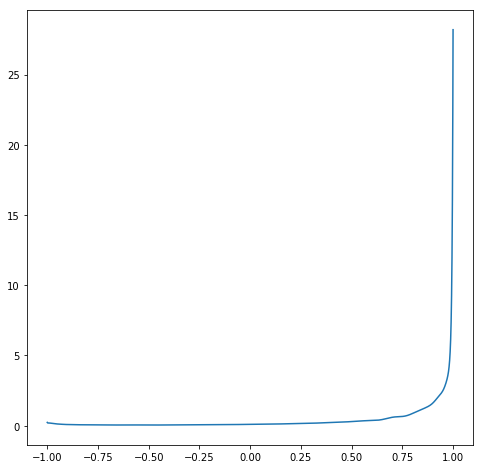

In [34]:
pf = pf[:int(pf.shape[0]/2)]
wavelengths = wavelengths[:int(wavelengths.shape[0]/2)]

mu = np.cos(wavelengths[::-1])
phase = pf[::-1]

plt.plot(mu, phase)

# Calculate the Legndre Coefficients

The (intensity) phase function is conventionally normalized as follows

$$\int_0^{2\pi} \int_0^\pi P(\Theta) \sin(\Theta) d\Theta d\phi = 4 \pi$$

Which is equivalent to

$$\int_{-1}^1 P(\cos{\Theta}) d(\cos{\Theta}) = 2$$

Integrating the phase function from vadim gives:

In [35]:
np.trapz(pf, mu)

0.81770539846279811

# Calculate the Legendre Coefficients

## Use quadrature integration

Note I am using linear interpolation. The reason is that higher order interpolation creates artifacts, probably due to the high directionality of the phase function.

In [38]:
COFFES_NUM = 300

In [39]:
phase_interp = interp1d(mu, phase, kind=1)

def func(x, l, lg):
    return (2*l + 1)/2. * lg(x)*phase_interp(x)

In [40]:
coeffs_quad = []
for l in tqdm_notebook(range(COFFES_NUM)):
    lg = legendre(l)
    #coeffs_quad.append(quad(func, -1, 1, args=(l, lg,), limit=1000)[0])
    #coeffs_quad.append(fixed_quad(func, -1, 1, args=(l, lg,), n=50000)[0])
    coeffs_quad.append(quadrature(func, -1, 1, args=(l, lg,), maxiter=1000)[0])

A Jupyter Widget

/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/special/orthogonal.py:142: RuntimeWarning: invalid value encountered in multiply
  self.__dict__['coeffs'] *= float(kn)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/special/orthogonal.py:1965: RuntimeWarning: overflow encountered in double_scalars
  kn = _gam(2 * n + 1) / _gam(n + 1)**2 / 2.0**n
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/special/orthogonal.py:1965: RuntimeWarning: invalid value encountered in double_scalars
  kn = _gam(2 * n + 1) / _gam(n + 1)**2 / 2.0**n


In [44]:
coeffs_quad[0]

0.40591120598307723

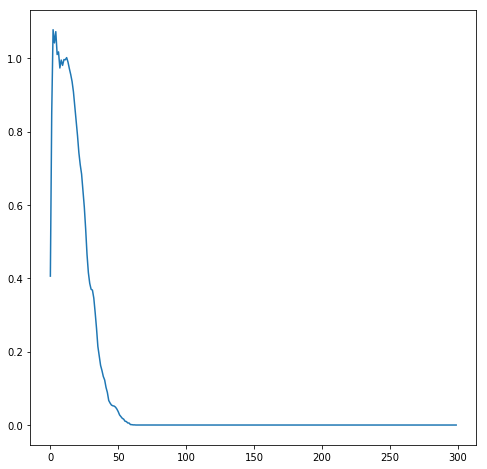

In [41]:
plt.plot(coeffs_quad)

## Reconstruct the Phase function by the Legndre coefficients

In [50]:
mu_new = np.linspace(-1, 1, 3000)
phase_gauss = 0
for l, coeff in enumerate(coeffs_quad):
    phase_gauss += legendre(l)(mu_new) * coeff
coeffs_quad_ = np.array(coeffs_quad)
coeffs_quad_ = coeffs_quad_ / coeffs_quad_[0]
phase_gauss_ = 0
for l, coeff in enumerate(coeffs_quad_):
    phase_gauss_ += legendre(l)(mu_new) * coeff

(0.9, 1)

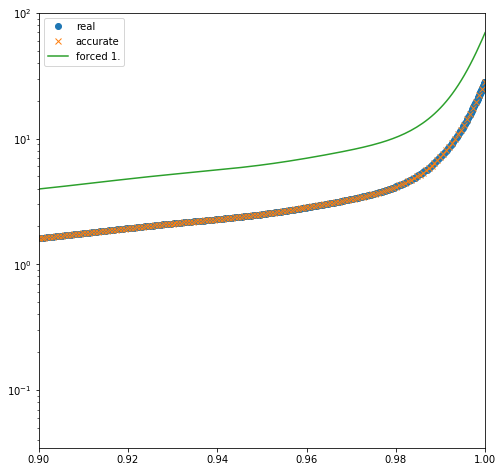

In [51]:
plt.semilogy(mu, phase, "o", label="real")
plt.semilogy(mu_new, phase_gauss, "x", label="accurate")
plt.semilogy(mu_new, phase_gauss_, label="forced 1.")
plt.legend()
plt.xlim(0.9, 1)

### Save the result

In [56]:
header = """! Mie scattering table vs. effective radius (LWC=1 g/m^3)
  0.{}    0.{}    0.000  wavelength range and averaging step (micron)
   2    1.450    1.450  number       starting       ending REAL refractive index
   2    0.000    0.000  number       starting       ending IMAGINARY refractive index
   2    0.100    0.100  number       starting       ending effective radius
   2    0.500    0.500  number       starting       ending effective variance
 """.format(WAVELENGTH, WAVELENGTH)
line_template = " 1.450 -.000     1.000    %f   0.5000   0.1000     %d  Phase function: Re{m}  Im{m}   Ext  Alb  Veff  Reff  Nleg\n"

In [62]:
with open("aerosol{}dredvedm_vadim_170422_{}.scat".format(WAVELENGTH, TIME_INDEX), "w") as f:
    f.write(header)
    for i in range(700):
        f.write(line_template % (ssa, len(coeffs_quad_)-1))
        f.write("\t".join(['']+[str(c) for c in coeffs_quad_]))
        f.write("\n")

In [63]:
with open("aerosol{}dredvedm_vadim_170422_{}_spssa.scat".format(WAVELENGTH, TIME_INDEX), "w") as f:
    f.write(header)
    for i in range(700):
        f.write(line_template % (0.862700, len(coeffs_quad_)-1))
        f.write("\t".join(['']+[str(c) for c in coeffs_quad_]))
        f.write("\n")

In [64]:
pwd

u'/home/amitibo/code/cameranetwork/notebooks/radiometric'

## Set the Target Time/Date And Wavelength

Note that I select 12:30 as there is no data for > 13:00 (due to Cirrus clouds). In any case the atmophsere doesn't not seem to change much during the analyzed period (12:00-14:00)

In [2]:
Image(url= "https://aeronet.gsfc.nasa.gov/cgi-bin/draw_piece_of_data_opera_v2_new?site=Technion_Haifa_IL&year=25&month=3&aero_water=0&level=2&day=25&if_err=0")

In [3]:
TIME = pd.datetime(2017, 4, 26, 6, 0, 0)
WAVELENGTH = 532

# Load the sunphotometer data

## Load the phasefunction

The data is loaded from the sunphotometer logs. Note that new values are interpolated for TIME and WAVELENGTH. I use the "pchip" interpolation method as it is more conservative.

In [4]:
def dateparse(d, t):
    return pd.datetime.strptime(d+' '+t, '%d:%m:%Y %H:%M:%S')

def parsePhaseFunction(path, usecols):
    """Parse the sunphotometer Phase Function data."""

    df = pd.read_csv(
        path,
        skiprows=3,
        header=0,
        parse_dates=[[0, 1]],
        date_parser=dateparse,
        index_col=0,
        usecols=usecols
    )

    wavelengths = [float(i.split("[")[0]) for i in df.columns]
    df = df.rename(columns=dict(itertools.izip(df.columns, wavelengths)))
    df.index.rename("datetime", inplace=True)
    
    new_row = pd.Series(name=TIME, data=[None]*len(df.columns), index=df.columns)
    df = df.append(new_row)
    df = df.sort_index().interpolate(method="pchip")

    return df, wavelengths

pfn_path = r"../../data/phase_functions/170426_170426_Technion_Haifa_IL.pfn"
df_441, wavelengths = parsePhaseFunction(
    pfn_path,
    usecols=[0, 1]+list(range(3, 86))
)
df_674, wavelengths = parsePhaseFunction(
    pfn_path,
    usecols=[0, 1]+list(range(86, 169))
)
df_871, wavelengths = parsePhaseFunction(
    pfn_path,
    usecols=[0, 1]+list(range(169, 252))
)
df_1020, wavelengths = parsePhaseFunction(
    pfn_path,
    usecols=[0, 1]+list(range(252, 335))
)

In [5]:
series = [pd.Series(d.loc[TIME], name=n) for d, n in zip((df_441, df_674, df_871, df_1020), (441., 674., 871., 1020.))]
df_phf = pd.concat(series, axis=1).T
new_row = pd.Series(name=WAVELENGTH, data=[None]*len(df_phf.columns), index=df_phf.columns)
df_phf = df_phf.append(new_row).sort_index().interpolate(method="pchip")

In [6]:
df_phf.head()

,0.0,1.71,3.93,6.16,8.39,10.63,12.86,15.1,17.33,19.57,...,160.43,162.67,164.9,167.14,169.37,171.61,173.84,176.07,178.29,180.0
441.0,593.089797,319.309741,96.742247,35.413453,17.873303,11.133267,7.849226,5.922031,4.711597,3.872969,...,0.123147,0.125328,0.128028,0.131764,0.137359,0.144943,0.155566,0.172087,0.188893,0.195157
532.0,417.981868,251.652042,92.144908,37.646075,19.262069,11.970263,8.455472,6.395315,5.098607,4.186915,...,0.140992,0.144319,0.148229,0.153552,0.160373,0.168115,0.179930,0.202922,0.227654,0.236211
674.0,239.452681,175.525504,84.369171,39.511368,21.078525,13.145684,9.271324,7.003542,5.581848,4.577176,...,0.159219,0.163552,0.168336,0.174523,0.181797,0.190017,0.205008,0.236111,0.268162,0.278478
871.0,147.989253,121.467606,72.292599,39.752822,22.931259,14.518637,10.151816,7.601654,6.028221,4.934054,...,0.168620,0.173150,0.177684,0.182897,0.188965,0.197989,0.218330,0.256707,0.290905,0.300952
1020.0,113.017567,97.663437,64.872895,39.233622,23.988745,15.541057,10.865553,8.091320,6.377170,5.199385,...,0.165563,0.169333,0.172435,0.175255,0.178950,0.187818,0.210826,0.250653,0.282759,0.291650


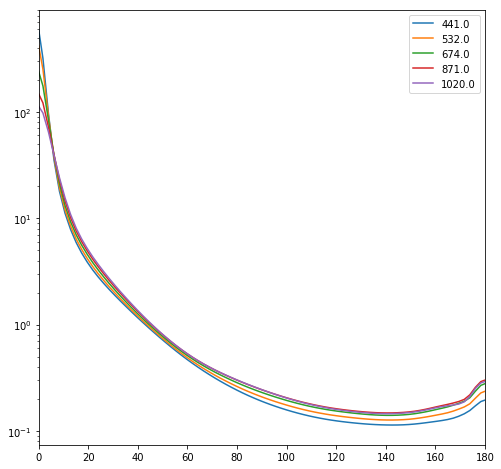

In [7]:
df_phf.T.plot(logy=True)

## Load the Single-Scatter Albedo

In [8]:
def parseSSA(path):
    """Parse the sunphotometer SSA data."""

    df = pd.read_csv(
        path,
        skiprows=3,
        header=0,
        parse_dates=[[0, 1]],
        date_parser=dateparse,
        index_col=0,
        usecols=[0, 1]+list(range(3, 7))
    )

    wavelengths = [float(i[3:-2]) for i in df.columns]
    df = df.rename(columns=dict(itertools.izip(df.columns, wavelengths)))
    df.index.rename("datetime", inplace=True)
    
    new_row = pd.Series(name=TIME, data=[None]*len(df.columns), index=df.columns)
    df = df.append(new_row)
    df = df.sort_index().interpolate(method="pchip")

    return df

ssa_path = r"../../data/phase_functions/170426_170426_Technion_Haifa_IL.ssa"

df_ssa = parseSSA(ssa_path)

### Interpolate by wavelength

In [9]:
new_row = pd.Series(name=WAVELENGTH, data=[None]*len(df_ssa.T.columns), index=df_ssa.T.columns)

df_ssa = df_ssa.T.append(new_row).sort_index().interpolate(method="pchip")

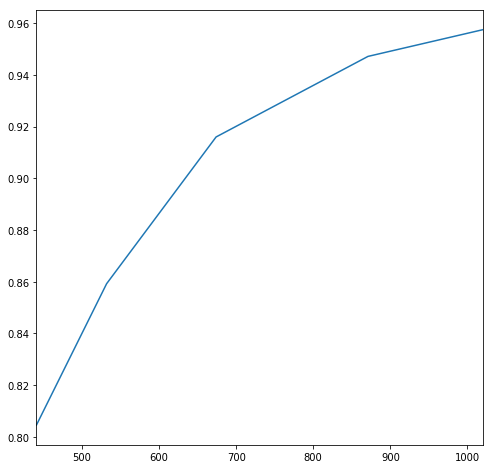

In [10]:
df_ssa.T.loc[TIME].T.plot()

In [11]:
df_ssa.loc[WAVELENGTH][TIME]

0.85924285177603721

## Load the AOD

In [12]:
def parseAOD(path):
    """Parse the sunphotometer AOD data."""

    df = pd.read_csv(
        path,
        skiprows=4,
        header=0,
        parse_dates=[[0, 1]],
        date_parser=dateparse,
        index_col=0,
        usecols=[0, 1]+list(range(3, 14))
    )

    df.index.rename("datetime", inplace=True)
    
    new_row = pd.Series(name=TIME, data=[None]*len(df.columns), index=df.columns)
    df = df.append(new_row)
    df = df.sort_index().interpolate(method="pchip")

    return df

aod_path = r"../../data/phase_functions/170426_170426_Technion_Haifa_IL.lev15"

df_aod = parseAOD(aod_path)

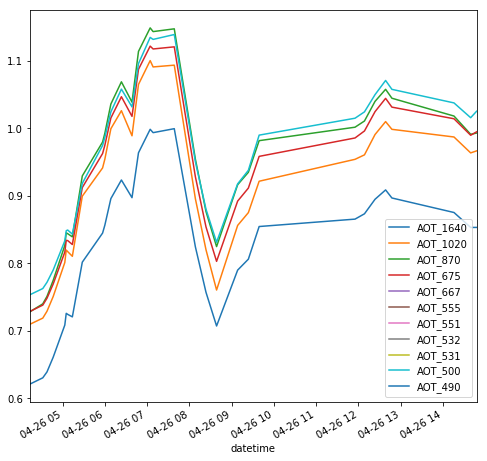

In [13]:
df_aod.plot()

In [14]:
df_aod.AOT_500[TIME]

0.98647427972328749

# Calculate the Legndre Coefficients

The (intensity) phase function is conventionally normalized as follows

$$\int_0^{2\pi} \int_0^\pi P(\Theta) \sin(\Theta) d\Theta d\phi = 4 \pi$$

Which is equivalent to

$$\int_{-1}^1 P(\cos{\Theta}) d(\cos{\Theta}) = 2$$

Integrating the phase function from the sunphotometer gives:

# Calculate the Legendre Coefficients

## Use quadrature integration

Note I am using linear interpolation. The reason is that higher order interpolation creates artifacts, probably due to the high directionality of the phase function.

In [15]:
COFFES_NUM = 300

In [16]:
mu = np.cos(np.radians(wavelengths[::-1]))
phase = df_phf.loc[WAVELENGTH].values[::-1]

phase_interp = interp1d(mu, phase, kind=1)

def func(x, l, lg):
    return (2*l + 1)/2. * lg(x)*phase_interp(x)

In [17]:
coeffs_quad = []
for l in tqdm_notebook(range(COFFES_NUM)):
    lg = legendre(l)
    #coeffs_quad.append(quad(func, -1, 1, args=(l, lg,), limit=1000)[0])
    #coeffs_quad.append(fixed_quad(func, -1, 1, args=(l, lg,), n=50000)[0])
    coeffs_quad.append(quadrature(func, -1, 1, args=(l, lg,), maxiter=1000)[0])

A Jupyter Widget

/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 2.647003e-05
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 4.399310e-05
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 6.123295e-05
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 9.474355e-05
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 1.111193e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: Accuracy

/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 8.929148e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 9.075227e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 9.164852e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 9.180226e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 9.134534e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: Accuracy

/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 8.769228e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 9.382531e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/special/orthogonal.py:1965: RuntimeWarning: overflow encountered in double_scalars
  kn = _gam(2 * n + 1) / _gam(n + 1)**2 / 2.0**n
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/special/orthogonal.py:1965: RuntimeWarning: invalid value encountered in double_scalars
  kn = _gam(2 * n + 1) / _gam(n + 1)**2 / 2.0**n
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 9.939264e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quad

/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 6.800029e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 6.858899e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 6.890665e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 6.897865e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 6.881281e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: Accuracy

/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 1.199157e-03
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 1.256892e-03
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 1.305272e-03
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 1.344059e-03
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 1.375119e-03
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: Accuracy

/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 1.608353e-03
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 1.560326e-03
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 1.515075e-03
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 1.472707e-03
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 1.433193e-03
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: Accuracy

/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 1.569075e-03
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 1.620744e-03
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 1.657833e-03
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 1.682416e-03
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 1.692807e-03
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: Accuracy

/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 7.106520e-04
  AccuracyWarning)


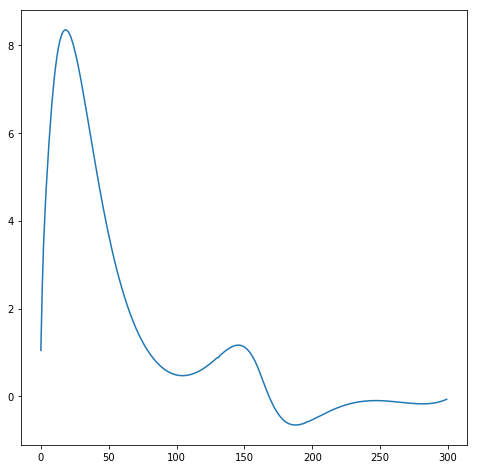

In [18]:
plt.plot(coeffs_quad)

## Reconstruct the Phase function by the Legndre coefficients

In [19]:
mu_new = np.linspace(-1, 1, 3000)
phase_gauss = 0
for l, coeff in enumerate(coeffs_quad):
    phase_gauss += legendre(l)(mu_new) * coeff
coeffs_quad_ = coeffs_quad[:]
coeffs_quad_[0] = 1.
phase_gauss_ = 0
for l, coeff in enumerate(coeffs_quad_):
    phase_gauss_ += legendre(l)(mu_new) * coeff

(0.9, 1)

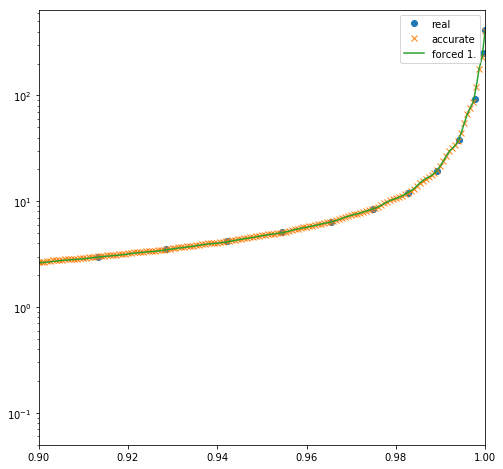

In [20]:
plt.semilogy(mu, phase, "o", label="real")
plt.semilogy(mu_new, phase_gauss, "x", label="accurate")
plt.semilogy(mu_new, phase_gauss_, label="forced 1.")
plt.legend()
plt.xlim(0.9, 1)

### Save the result

In [21]:
header = """! Mie scattering table vs. effective radius (LWC=1 g/m^3)
  0.{}    0.{}    0.000  wavelength range and averaging step (micron)
   2    1.450    1.450  number       starting       ending REAL refractive index
   2    0.000    0.000  number       starting       ending IMAGINARY refractive index
   2    0.100    0.100  number       starting       ending effective radius
   2    0.500    0.500  number       starting       ending effective variance
 """.format(WAVELENGTH, WAVELENGTH)
line_template = " 1.450 -.000     1.000    %f   0.5000   0.1000     %d  Phase function: Re{m}  Im{m}   Ext  Alb  Veff  Reff  Nleg\n"

In [22]:
with open(TIME.strftime("aerosol{}dredvedm__%Y%m%d_%H%M".format(WAVELENGTH)), "w") as f:
    f.write(header)
    for i in range(700):
        f.write(line_template % (df_ssa.loc[WAVELENGTH][TIME], len(coeffs_quad_)-1))
        f.write("\t".join(['']+[str(c) for c in coeffs_quad_]))
        f.write("\n")